In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import make_quantiles

sns.set_style('whitegrid')

C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])

In [4]:
ar6_data = pd.read_csv(data_path / 'AR6_Scenarios_Database_World_v1.0.csv')
ar6_data = ar6_data[ar6_data.Variable.isin(['Emissions|CO2|AFOLU'])]

In [5]:
df = pyam.IamDataFrame(pd.concat([paper_data, ar6_data]))
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators for 914 out of 1874 scenarios


In [6]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [7]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020',
 'Cumulative AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Cumulat

# Panel 1A

In [8]:
variables = [
    'Emissions|CO2|AFOLU',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
]

data = pyam.concat([
    make_quantiles(df, v, cat)
    for v, cat in itertools.product(variables, categories_to_temp.keys())
])

In [9]:
def afolu_line_plot(data, variables, cat, ax=None, years=range(1990, 2051), color='variable'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.25*', '*0.75*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, fill_between=True, ax=ax, alpha=0.1, legend=False) #  cmap='PiYG_r',
    )
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.5*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, ax=ax)  # cmap='PiYG_r',
    )
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-len(variables):], l[-len(variables):])
    return ax

In [10]:
color_map = {
    'Emissions|CO2|AFOLU': '#' + 'c' * 6,
    'LULUCF Emissions - BK/IAM Reporting Convensions': '#33701a',
    'LULUCF Emissions - NGHGI Reporting Conventions': '#a3176d', 
}
pyam.run_control().update({'color': {'variable': color_map}})

In [11]:
error = pd.read_excel(data_path / 'LUC_uncertainty_AR6_reanalysis.xlsx', sheet_name='Fig1AB')

C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


<Axes: >

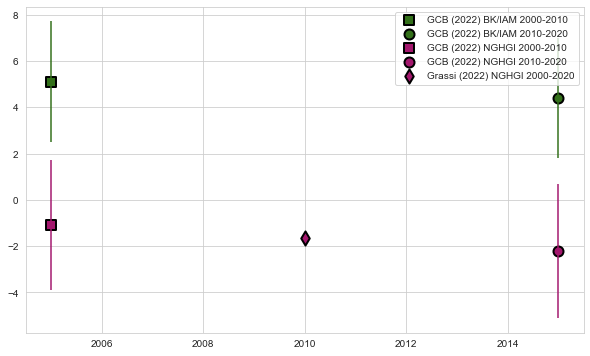

In [12]:
def add_eluc_history(error, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    colors = {
        'BK/IAM': '#33701a',
        'NGHGI': '#a3176d', 
    }
    markers = {
        '2000-2010': 's',
        '2010-2020': 'o', 
        '2000-2020': 'd',
    }
    for i, row in error.iterrows():
        label = ' '.join((row['label'], row['emissions'], row['period']))
        ax.scatter(row['plot_year'], row['mean'], marker=markers[row['period']],  label=label, 
                   color=colors[row['emissions']], s=100, edgecolor='k', linewidths=2)
        ax.errorbar(row['plot_year'], row['mean'], row['std'], color=colors[row['emissions']])
    ax.legend()
    return ax

add_eluc_history(error)

C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


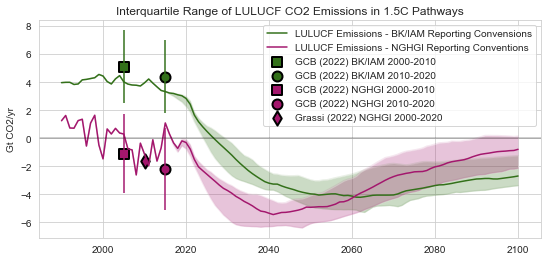

In [13]:
cat = 'C1'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - BK/IAM Reporting Convensions',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Reporting Conventions', 
}
fig, ax = plt.subplots(figsize=(9, 4))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
add_eluc_history(error, ax=ax)
ax.axhline(0, c='k', alpha=0.25)

ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')
h, l = ax.get_legend_handles_labels()
ax.legend(h[-7:], l[-7:])

fig.savefig('./files/fig1a1.pdf')

C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


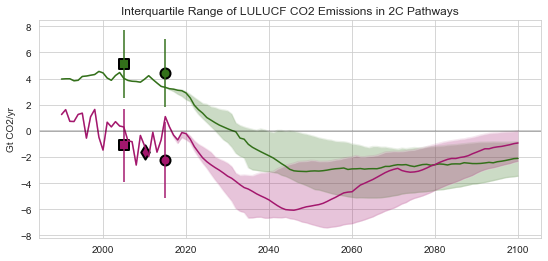

In [14]:
cat = 'C3'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - BK/IAM Reporting Convensions',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Reporting Conventions', 
}
fig, ax = plt.subplots(figsize=(9, 4))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
add_eluc_history(error, ax=ax)
ax.axhline(0, c='k', alpha=0.25)

ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')
ax.legend().remove()

fig.savefig('./files/fig1a2.pdf')

# Panel 1B

In [15]:
error = pd.read_excel(data_path / 'LUC_uncertainty_AR6_reanalysis.xlsx', sheet_name='Fig1C')
error

,label,period,plot_year,mean,std
0,Grassi (2023),2000-2020,2009,6.7,2.5
1,GCB (2022),2000-2020,2011,6.4,1.2
2,OSCAR (this study),2000-2020,2012,4.4,1.0


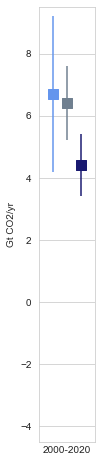

In [16]:
fig, ax = plt.subplots(figsize=(1, 8))
markers = {
    '2000-2020': 's',
    '2000-2010': 'd',
    '2005-2015': 'o', 
    '2010-2020': '*',
}
colors = {
    'GCB (2022)': 'slategrey',
    'Grassi (2021)': 'royalblue', 
    'Grassi (2023)': 'cornflowerblue',
    'OSCAR (this study)': 'midnightblue',
}
for i, row in error.iterrows():
    label = ' '.join((row['label'], row['period']))
    ax.scatter(-1 + i, row['mean'], marker=markers[row['period']],  label=label, color=colors[row['label']], s=100)
    ax.errorbar(-1 + i, row['mean'], row['std'], color=colors[row['label']])

# set xticks
ax.set_xlim((-2, 2))
ax.set_xticks([])
ax.set_xlabel('2000-2020')

# conform with below plot
ax.set_ylabel('Gt CO2/yr')
plt.grid(axis='x', visible=False)

## This block should be commented/uncommented to get adobe-ready versions
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

# harmonize ylim
ax.set_ylim(-4.5, 9.5)

fig.savefig('./files/fig1b1.pdf', bbox_inches='tight')

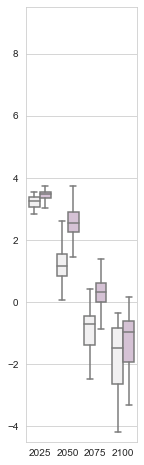

In [17]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
]
name = 'NGHGI LULUCF Gap'
fig, ax = plt.subplots(figsize=(2, 8))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2025, 2101, 25))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_xlabel('')

## This block should be commented/uncommented to get adobe-ready versions
#ax.set_title(name)
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])
ax.legend().remove()

# conform with previous plot
ax.set_ylabel('')

# harmonize ylim
ax.set_ylim(-4.5, 9.5)

fig.savefig('./files/fig1b2.pdf', bbox_inches='tight')

Text(0.5, 0, '')

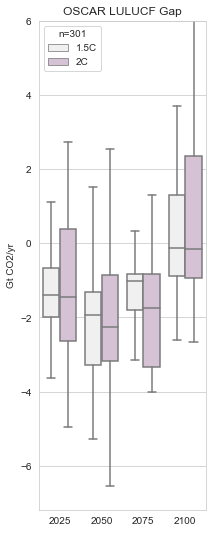

In [18]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'Emissions|CO2|AFOLU', 
]
name = 'OSCAR LULUCF Gap'
fig, ax = plt.subplots(figsize=(3, 9))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2025, 2101, 25))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_title(name)
ax.set_ylim(None, 6)
ax.set_xlabel('')

# SI Table of Indirect Flux

In [19]:
def data_range(df, region, category, year, variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect'):
    category_kwarg = {'Category': category} if category.startswith('C') else {'Policy_category_name': category}
    data = (
        df
        .filter(region=region, variable=variable, year=year)
        .filter(**category_kwarg)
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .compute.quantiles([0.25, 0.5, 0.75])
        ['value']
    )
    return data[1], data[0], data[2] # 0.5, 0.25, 0.75

regions = df.region
years = [2025, 2050, 2075, 2100]
categories = ['C1', 'C2', 'C3']

idx = pd.MultiIndex.from_product([regions, categories, years], names=["Region", "Category",  "Year"])
table = (
    pd.Series([
        '{:.2f} [{:.2f}, {:.2f}]'.format(*data_range(df, region, category, year)) for region, category, year in idx
    ], index=idx)
    .unstack(level=['Category', 'Year'])
)
table.head()

Category                       C1                                              \
Year                         2025                  2050                  2075   
Region                                                                          
R5ASIA       -1.03 [-1.08, -0.99]  -0.39 [-0.50, -0.28]     0.23 [0.16, 0.40]   
R5LAM           0.27 [0.22, 0.37]     0.48 [0.38, 0.60]     0.50 [0.39, 0.68]   
R5MAF        -0.49 [-0.52, -0.46]  -0.07 [-0.12, -0.02]     0.19 [0.15, 0.31]   
R5OECD90+EU  -1.12 [-1.15, -1.11]  -0.64 [-0.69, -0.57]   -0.03 [-0.09, 0.10]   
R5REF        -0.85 [-0.86, -0.85]  -0.58 [-0.61, -0.54]  -0.20 [-0.23, -0.12]   

Category                                           C2                        \
Year                       2100                  2025                  2050   
Region                                                                        
R5ASIA        0.46 [0.25, 0.71]  -1.04 [-1.08, -1.01]  -0.63 [-0.76, -0.52]   
R5LAM         0.48 [0.33, 0.79]     0.17 [0.13, 0.27]     0.35 [0.23, 0.45]   
R5MAF         0.24 [0.17, 0.41]  -0.52 [-0.54, -0.50]  -0.20 [-0.26, -0.15]   
R5OECD90+EU   0.25 [0.13, 0.48]  -1.15 [-1.16, -1.13]  -0.87 [-0.96, -0.78]   
R5REF        0.02 [-0.05, 0.13]  -0.87 [-0.88, -0.86]  -0.72 [-0.79, -0.67]   

Category                                                                C3  \
Year                         2075               2100                  2025   
Region                                                                       
R5ASIA          0.22 [0.13, 0.37]  0.77 [0.62, 0.89]  -1.05 [-1.09, -1.03]   
R5LAM           0.57 [0.48, 0.72]  0.85 [0.69, 0.94]     0.16 [0.12, 0.26]   
R5MAF           0.23 [0.16, 0.30]  0.50 [0.35, 0.59]  -0.53 [-0.54, -0.51]   
R5OECD90+EU   -0.09 [-0.16, 0.05]  0.52 [0.39, 0.62]  -1.15 [-1.17, -1.14]   
R5REF        -0.26 [-0.30, -0.17]  0.13 [0.07, 0.20]  -0.87 [-0.88, -0.86]   

Category                                                                       
Year                         2050                  2075                  2100  
Region                                                                         
R5ASIA       -0.77 [-0.89, -0.68]   -0.04 [-0.12, 0.04]     0.31 [0.23, 0.56]  
R5LAM           0.24 [0.15, 0.33]     0.38 [0.30, 0.46]     0.50 [0.39, 0.71]  
R5MAF        -0.27 [-0.31, -0.22]     0.08 [0.03, 0.12]     0.21 [0.14, 0.39]  
R5OECD90+EU  -0.98 [-1.05, -0.91]  -0.33 [-0.40, -0.24]     0.09 [0.03, 0.30]  
R5REF        -0.79 [-0.83, -0.74]  -0.40 [-0.44, -0.35]  -0.11 [-0.15, -0.02]

In [20]:
table.T.to_excel('./files/indirect_flux_values_test.xlsx', index=True)

# Table of median removals and emissions

In [21]:
categories = ['C1', 'P1b: Current policies']
regions = ['World']
years = [2050]
idx = pd.MultiIndex.from_product([regions, categories, years], names=["Region", "Category",  "Year"])

In [22]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
]
for variable in variables:
    table = (
        pd.Series([
            '{:.2f} [{:.2f}, {:.2f}]'.format(*data_range(df, region, category, year, variable=variable)) for region, category, year in idx
        ], index=idx)
        .unstack(level=['Category', 'Year'])
    )
    print(variable)
    print(table)

AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct
Category                 C1 P1b: Current policies
Year                   2050                  2050
Region                                           
World     5.44 [3.62, 6.29]     2.14 [2.09, 2.46]
AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect
Category                 C1 P1b: Current policies
Year                   2050                  2050
Region                                           
World     1.15 [0.83, 1.56]     5.29 [4.90, 5.59]
AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct
Category                    C1 P1b: Current policies
Year                      2050                  2050
Region                                              
World     -3.97 [-4.88, -2.97]    0.06 [-0.50, 1.26]
AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect
Category                    C1 P1b: Current policies
Year                      2050                  2050
Region                                              
World     -1.15 [